In [1]:
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy import sparse
import anndata
import seaborn as sns
import scvelo as scv
import multivelo as mv


In [2]:
import sys
sys.path.append("../src/")
import MoFlow as mf

In [3]:
import matplotlib
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.facecolor': 'white'})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

matplotlib.rcParams['ytick.labelright'] = False
matplotlib.rcParams['ytick.labelleft'] = True
matplotlib.rcParams['ytick.right'] = False
matplotlib.rcParams['ytick.left'] = True

In [4]:
multivelo = anndata.read_h5ad(
    '../data/Human_brain/multivelo_result.h5ad')
celldancer = anndata.read_h5ad(
    '../data/Human_brain/celldancer.h5ad')

In [5]:

#adata_out = anndata.read_h5ad(
#    '../data/Human_brain/adata_out.moflow.h5ad')
adata_out = anndata.read_h5ad(
    '../data/Human_brain/adata_out.moflow.mvstyle.h5ad')

In [6]:
adata_out

AnnData object with n_obs × n_vars = 4693 × 842
    obs: 'cluster', 'batch', 'n_counts', 'celltype_new', 'velo_s_self_transition', 'root_cells', 'end_points', 'velo_s_pseudotime'
    var: 'loss', 'epoch', 'direction', 'slope'
    uns: 'celltype_new_colors', 'cluster_colors', 'neighbors', 'pca', 'umap', 'velo_s_graph', 'velo_s_graph_neg', 'velo_s_params'
    obsm: 'X_pca', 'X_umap', 'velo_s_umap'
    varm: 'PCs'
    layers: 'Mc', 'Ms', 'Mu', 'alpha', 'alpha_c', 'beta', 'c', 'gamma', 's', 'spliced', 'stateoff', 'stateon', 'u', 'unspliced', 'velo_c', 'velo_s', 'velo_u'
    obsp: 'connectivities', 'distances'

saving figure to file ../figures/fig2A_mosync.svg


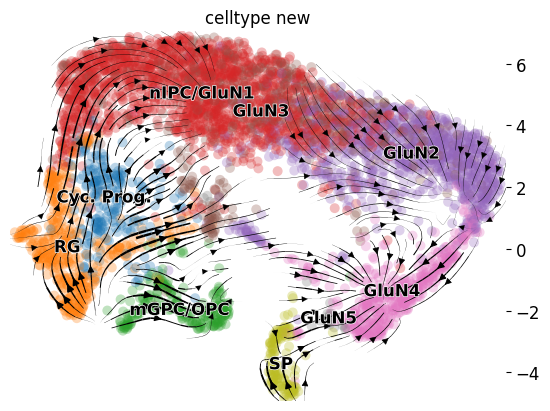

In [7]:
scv.pl.velocity_embedding_stream(adata_out,
                                 vkey='velo_s',
                                 color='celltype_new',
                                 save='../figures/fig2A_mosync.svg')

In [7]:
pseudotime_ = np.zeros(adata_out.n_obs)
pseudotime_[np.argsort(adata_out.obs['velo_s_pseudotime'])] = np.arange(adata_out.n_obs)
adata_out.obs['velo_s_pseudotime_'] = pseudotime_/adata_out.n_obs

saving figure to file ../figures/fig2A_time.pdf


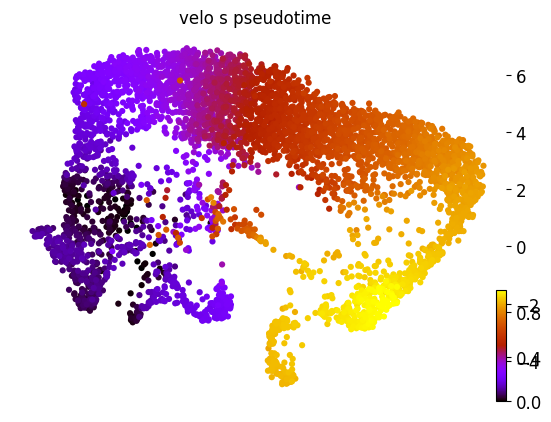

In [8]:
scv.pl.scatter(adata_out,
                vkey='velo_s',
                color='velo_s_pseudotime_', cmap='gnuplot', size=80,
                save='../figures/fig2A_time.pdf')

computing velocity graph (using 1/255 cores)


  0%|          | 0/4693 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velo_s_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velo_s_umap', embedded velocity vectors (adata.obsm)
saving figure to file ../figures/fig2A_multivelo.svg


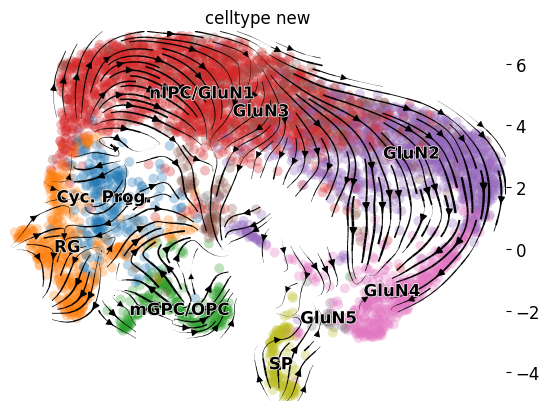

In [11]:
scv.tl.velocity_graph(multivelo, vkey='velo_s')
scv.pl.velocity_embedding_stream(multivelo,
                                 vkey='velo_s',
                                 color='celltype_new',
                                 save='../figures/fig2A_multivelo.svg')

saving figure to file ../figures/fig2A_multivelo.svg


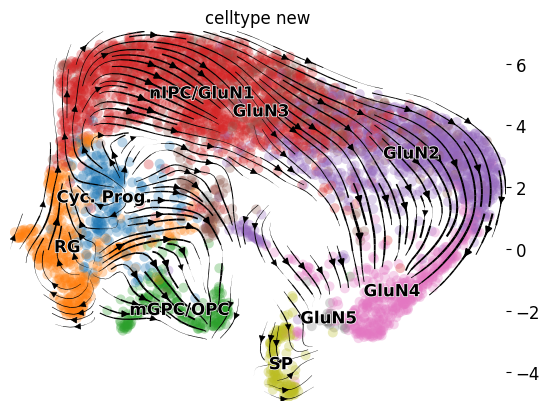

In [11]:
scv.pl.velocity_embedding_stream(multivelo,
                                 vkey='velo_s_norm',
                                 color='celltype_new',
                                 save='../figures/fig2A_multivelo.svg')

saving figure to file ../figures/fig2A_celldancer.svg


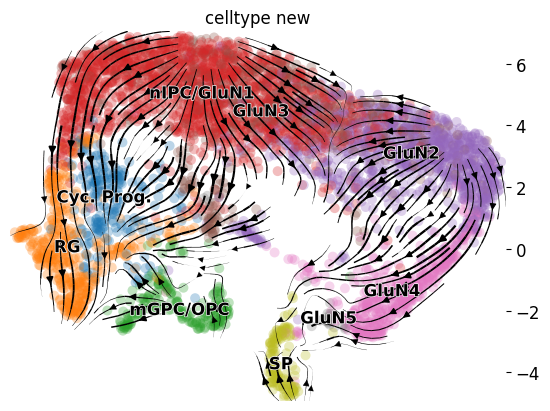

In [12]:
scv.pl.velocity_embedding_stream(celldancer,
                                 vkey='velo_s',
                                 color='celltype_new',
                                 save='../figures/fig2A_celldancer.svg')

In [39]:
scv.tl.score_genes_cell_cycle(adata_out)

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


saving figure to file ../figures/fig2C_g2m.pdf


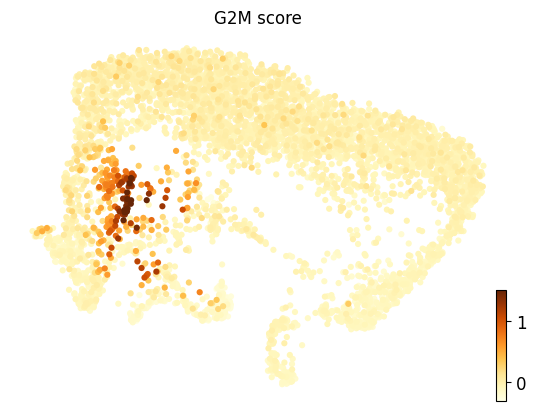

In [51]:
scv.pl.scatter(adata_out, color='G2M_score', color_map='YlOrBr', vmax=1.5, size=80,
                save='../figures/fig2C_g2m.pdf')


In [8]:
labels = pd.read_csv('../temps/250208_humanbrain_cluster.csv', 
                     index_col=0)

In [7]:
cluster_edges = (('Cyc. Prog.', 'RG'), ('RG',  'nIPC/GluN1'), ('RG','mGPC/OPC' ), ('nIPC/GluN1', 'GluN2'),
                 ('nIPC/GluN1', 'GluN3'), ('GluN3', 'GluN2'), ('GluN2', 'GluN4'), ('GluN5', 'GluN4'),
                 ('SP', 'GluN4'), ('SP', 'GluN5'))

In [19]:
cbdir = {}

In [20]:
cbdir['moflow'] = mf.cross_boundary_correctness(adata_out, 'celltype_new', 'velo_s', cluster_edges,
                                          True, 'X_umap')
cbdir['celldancer'] = mf.cross_boundary_correctness(celldancer, 'celltype_new', 'velo_s', cluster_edges,
                                          True, 'X_umap')
cbdir['multivelo'] = mf.cross_boundary_correctness(multivelo, 'celltype_new', 'velo_s_norm', cluster_edges,
                                          True, 'X_umap')

In [21]:
cbdir_ = []
for k in cbdir.values():
    temp = {}
    for c, s in k.items():
        s = np.mean(s)
        temp[c] = s
    cbdir_.append(temp)
    
cbdir_ = pd.DataFrame(cbdir_, index=cbdir.keys())

In [22]:
cbdir_

,"(Cyc. Prog., RG)","(RG, nIPC/GluN1)","(RG, mGPC/OPC)","(nIPC/GluN1, GluN2)","(nIPC/GluN1, GluN3)","(GluN3, GluN2)","(GluN2, GluN4)","(GluN5, GluN4)","(SP, GluN4)","(SP, GluN5)"
moflow,-0.189318,0.738256,-0.165059,0.369706,0.142651,0.369766,0.566429,0.646496,0.313349,0.735205
celldancer,0.082328,-0.748191,0.314838,0.271633,-0.099508,0.174163,0.290839,-0.514233,0.081400,0.204612
multivelo,0.420252,0.671514,0.058462,0.452228,0.083891,0.381768,0.648765,-0.292496,-0.071841,-0.072267


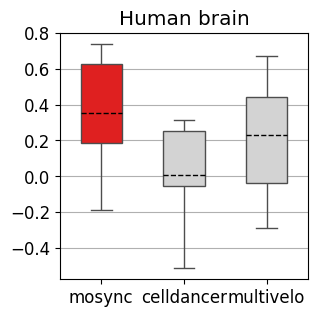

In [30]:
fig, ax = plt.subplots(figsize=(3.2, 3.2))
sns.boxplot(cbdir_.T, palette=['red', 'lightgrey', 'lightgrey'], medianprops=dict(linewidth=0),
            meanline=True, showmeans=True, width=.5, meanprops=dict(color='black'), showfliers=False)
plt.title('Human brain')
plt.grid(axis='y')
fig.savefig('../figures/fig2B_cbdir.pdf')

In [23]:
print(cbdir_.mean(axis=1))
print(cbdir_.std(axis=1))

moflow        0.352748
celldancer    0.005788
multivelo     0.228028
dtype: float64
moflow        0.339127
celldancer    0.361615
multivelo     0.330845
dtype: float64


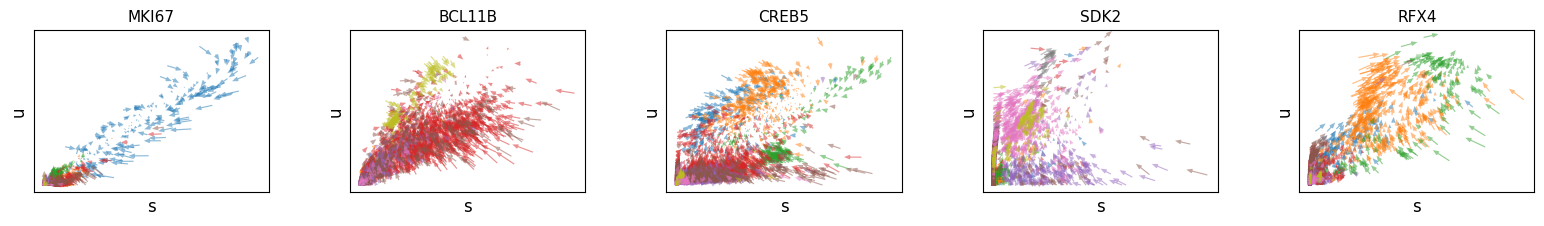

In [10]:
fig, axes = mf.scatter_gene(adata_out,
    gene_list=['MKI67','BCL11B', 'CREB5', 'SDK2', 'RFX4'],
    color_by='celltype_new',
    velocity_arrows=True,
    )
for ax in axes[0]:
    ax.set_xticks([])
    ax.set_yticks([])
fig.savefig('../figures/fig2C_us.pdf')

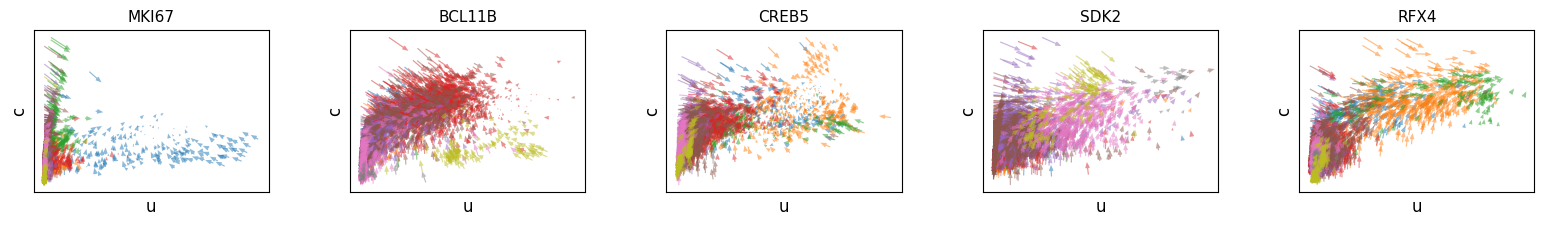

In [11]:
fig, axes = mf.scatter_gene(adata_out,
    gene_list=['MKI67','BCL11B', 'CREB5', 'SDK2', 'RFX4'],
    color_by='celltype_new',
    velocity_arrows=True, by='cu'
    )
for ax in axes[0]:
    ax.set_xticks([])
    ax.set_yticks([])
fig.savefig('../figures/fig2C_cu.pdf')

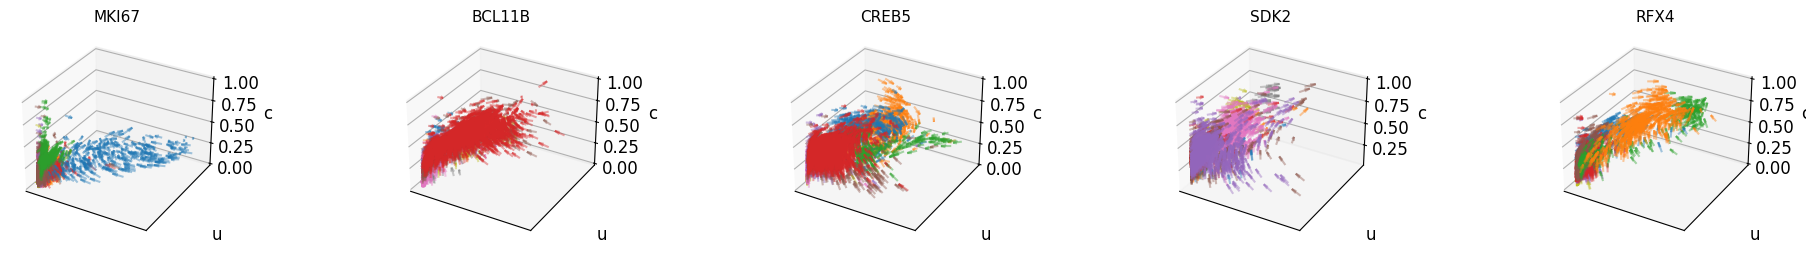

In [18]:
fig, axes = mf.scatter_gene(adata_out,
    gene_list=['MKI67','BCL11B', 'CREB5', 'SDK2', 'RFX4'],
    color_by='celltype_new',
    velocity_arrows=True, by='cus'
    )
for ax in axes[0]:
    ax.set_xticks([])
    ax.set_yticks([])
fig.savefig('../figures/fig2C_S_cus.pdf')

In [19]:
multivelo.layers['Mc'] = multivelo.layers['ATAC']
multivelo.layers['velo_c'] = multivelo.layers['velo_chrom']

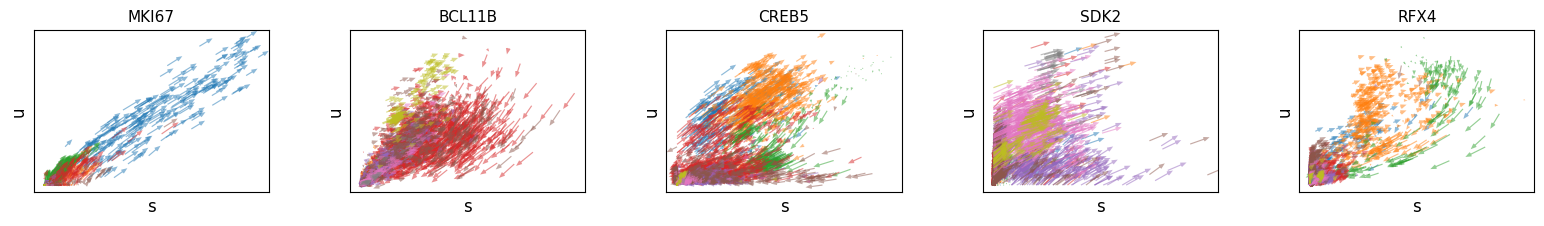

In [20]:
fig, axes = mf.scatter_gene(multivelo,
    gene_list=['MKI67','BCL11B', 'CREB5', 'SDK2', 'RFX4'
],
    color_by='celltype_new',
    velocity_arrows=True,
    )
for ax in axes[0]:
    ax.set_xticks([])
    ax.set_yticks([])
fig.savefig('../figures/fig2C_S_multivelo_us.pdf')

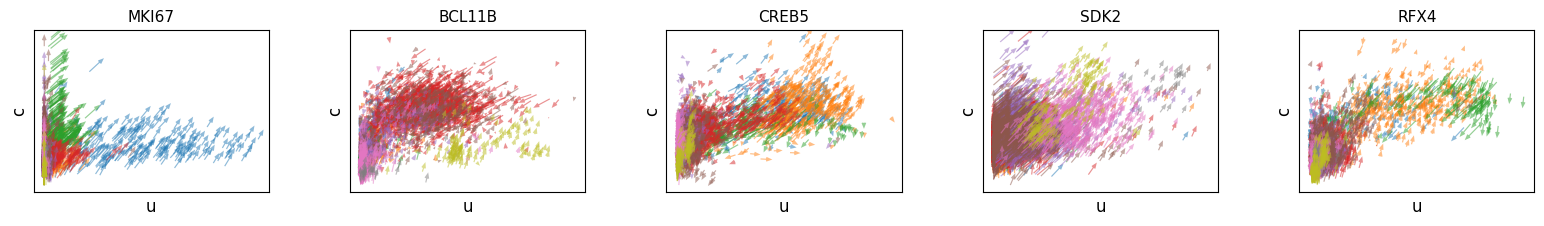

In [21]:
fig, axes = mf.scatter_gene(multivelo,
    gene_list=['MKI67','BCL11B', 'CREB5', 'SDK2', 'RFX4'
],
    color_by='celltype_new',
    velocity_arrows=True, by='cu'
    )
for ax in axes[0]:
    ax.set_xticks([])
    ax.set_yticks([])
fig.savefig('../figures/fig2C_S_multivelo_cu.pdf')

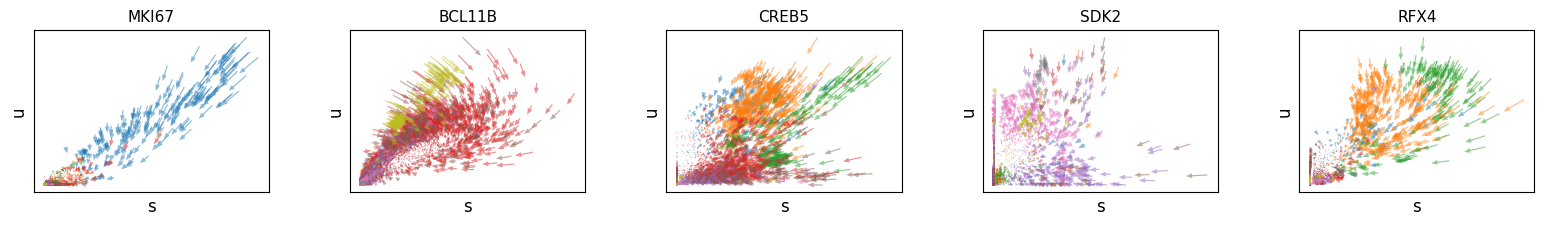

In [22]:
fig, axes = mf.scatter_gene(celldancer,
    gene_list=['MKI67','BCL11B', 'CREB5', 'SDK2', 'RFX4'
],
    color_by='celltype_new',
    velocity_arrows=True,
    )
for ax in axes[0]:
    ax.set_xticks([])
    ax.set_yticks([])
fig.savefig('../figures/fig2C_S_celldancer_us.pdf')

In [10]:
model = np.zeros(adata_out.n_vars).astype(str)
on_ = np.zeros(adata_out.n_vars)
off_ = np.zeros(adata_out.n_vars)
m1_ = np.zeros(adata_out.n_vars)
m2_ = np.zeros(adata_out.n_vars)

for i, g in enumerate(adata_out.var_names):
    c = adata_out[:, g].layers['c'].ravel()
    u = adata_out[:, g].layers['u'].ravel()
    s = adata_out[:, g].layers['s'].ravel()
    
    vc = adata_out[:, g].layers['velo_c'].ravel()
    vs = adata_out[:, g].layers['velo_s'].ravel()
    vu = adata_out[:, g].layers['velo_u'].ravel()
    
    w_non_zero = ((c >= 0.1 * np.max(c)) &
                    (u >= 0.1 * np.max(u)) &
                    (s >= 0.1 * np.max(s)))
    u_non_zero = u[w_non_zero]
    s_non_zero = s[w_non_zero]
    wu = u >= np.percentile(u_non_zero, 90)
    ws = s >= np.percentile(s_non_zero, 90)
    
    #ww = wu|ws&down
    ww = wu|ws
    ww |= (vu * vs >= 0)
    
    on_[i] = np.mean((vu[w_non_zero]>0)&(vs[w_non_zero]>0))
    off_[i] = np.mean((vu[w_non_zero]<0)&(vs[w_non_zero]<0))
    m1_[i] = np.mean((vc[ww]<0)&(vu[ww]>0))
    m2_[i] = np.mean((vc[ww]>0)&(vu[ww]<0))
    #m1_[i] = np.mean((vc[ww]<0))
    #m2_[i] = np.mean((vc[ww]>=0))
    

    
    

In [11]:
temp = pd.DataFrame({'on': on_, 'off': off_,
                     'm1': m1_, 'm2': m2_,},
                    index=adata_out.var_names)

In [12]:
temp['m1'] = temp['m1']/(temp['m1'] + temp['m2'])
temp['m2'] = temp['m2']/(temp['m1'] + temp['m2'])

In [13]:
temp['label'] = labels['label']

In [14]:
genelist = set(adata_out.var_names) & set(multivelo.var_names)
adata_out_ = adata_out[:, adata_out.var_names.isin(genelist)]
multivelo_ = multivelo[:, multivelo.var_names.isin(genelist)]

In [15]:
temp_ = temp.loc[ multivelo_.var_names.values]
temp_['fit_model'] = multivelo_.var['fit_model']
temp_['fit_direction'] = multivelo_.var['fit_direction']

In [14]:
from scipy import stats

In [15]:
temp_

,on,off,m1,m2,label,fit_model,fit_direction
ABCC9,0.934363,0.000000,0.690909,0.006271,3.0,1.0,on
ABHD3,0.062500,0.391098,0.306383,0.366313,1.0,1.0,complete
ABLIM1,0.124260,0.351479,0.279167,0.165267,6.0,1.0,complete
ABTB2,0.542113,0.001531,0.909361,0.015564,3.0,1.0,on
ACHE,0.000000,0.210000,0.222826,0.159492,4.0,1.0,on
...,...,...,...,...,...,...,...
ZNF331,0.476514,0.003090,0.947557,0.013369,4.0,1.0,complete
ZNF385B,0.767081,0.006211,0.984375,0.000226,5.0,1.0,on
ZNF385D,0.298246,0.245614,0.736111,0.018330,5.0,1.0,complete
ZNF521,0.479484,0.016413,0.708502,0.025789,3.0,1.0,on


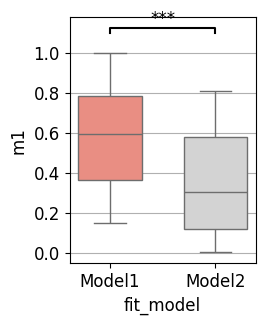

In [ ]:
fig, ax = plt.subplots(figsize=(2.4, 3.2))
sns.boxplot(temp_, y='m1', x='fit_model',
             fill=True, palette=['salmon', 'lightgrey'],  
             width=.6, whis=.5, showfliers=False)
ax.grid(axis='y')
ax.set_xticklabels(['Model1', 'Model2'])

ylim = ax.get_ylim()
yrange = ylim[1] - ylim[0]
h = 0.02*yrange
offset = 0.05 * yrange
y = ylim[1] + offset
x1, x2 = 0, 1
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black')
ax.text((x1+x2)/2, y+h*2, '***', ha='center')



fig.savefig('../figures/fig2D_mvmodel_m1.pdf')

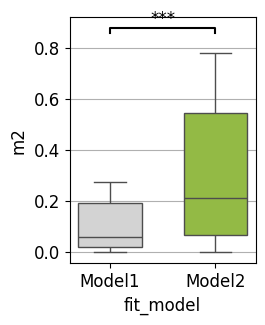

In [53]:
fig, ax = plt.subplots(figsize=(2.4, 3.2))
sns.boxplot(temp_, y='m2', x='fit_model',
             fill=True, palette=['lightgrey', 'yellowgreen'],
             width=.6, whis=.5, showfliers=False)
ax.grid(axis='y')
ax.set_xticklabels(['Model1', 'Model2'])
#ax.set_ylim(-.05, 1.05)

ylim = ax.get_ylim()
yrange = ylim[1] - ylim[0]
h = 0.02*yrange
offset = 0.05 * yrange
y = ylim[1] + offset
x1, x2 = 0, 1
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black')
ax.text((x1+x2)/2, y+h*2, '***', ha='center')

fig.savefig('../figures/fig2D_mvmodel_m2.pdf')

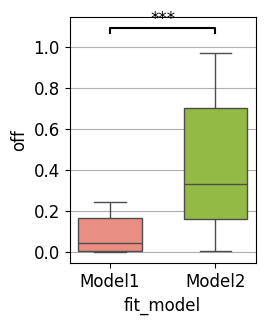

In [55]:
fig, ax = plt.subplots(figsize=(2.4, 3.2))
sns.boxplot(temp_, y='off', x='fit_model',
             fill=True, palette=['salmon', 'yellowgreen'], width=.6, whis=.5, showfliers=False)
ax.grid(axis='y')
ax.set_xticklabels(['Model1', 'Model2'])

ylim = ax.get_ylim()
yrange = ylim[1] - ylim[0]
h = 0.02*yrange
offset = 0.05 * yrange
y = ylim[1] + offset
x1, x2 = 0, 1
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black')
ax.text((x1+x2)/2, y+h*2, '***', ha='center')

fig.savefig('../figures/fig2D_mvmodel_off.pdf')

In [225]:
stats.ttest_ind(temp_[temp_['fit_model']==1]['m1'], temp_[temp_['fit_model']==2]['m1'],
                equal_var=False, alternative='greater')

TtestResult(statistic=6.292837575249676, pvalue=3.974181229382419e-09, df=101.75029057237623)

In [226]:
stats.ttest_ind(temp_[temp_['fit_model']==1]['m2'], temp_[temp_['fit_model']==2]['m2'],
                equal_var=False, alternative='less')

TtestResult(statistic=-5.308129819135566, pvalue=3.810857091133294e-07, df=92.05041192510937)

In [269]:
stats.ttest_ind(temp_[temp_['fit_model']==1]['off'], temp_[temp_['fit_model']==2]['off'],
                equal_var=False, alternative='less')

TtestResult(statistic=-8.442936468196416, pvalue=2.633551145244949e-13, df=89.15443754167619)

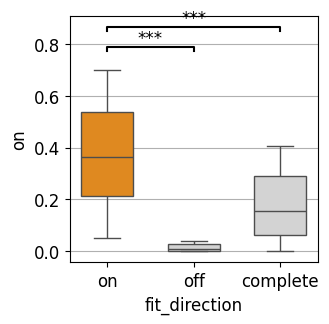

In [24]:
fig, ax = plt.subplots(figsize=(3.2, 3.2))
sns.boxplot(temp_, y='on', x='fit_direction',
             fill=True, palette=['darkorange', 'lightgrey', 'lightgrey'], 
             order=['on', 'off', 'complete'], width=.6, whis=.5, showfliers=False)

ylim = ax.get_ylim()
yrange = ylim[1] - ylim[0]
h = 0.02*yrange
offset = 0.05 * yrange
y = ylim[1] + offset
x1, x2 = 0, 1
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black')
ax.text((x1+x2)/2, y+h*2, '***', ha='center')

x1, x2 = 0, 2
y = y+h*5
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black')
ax.text((x1+x2)/2, y+h*2, '***', ha='center')


ax.grid(axis='y')
fig.savefig('../figures/fig2D_S_mvmodel_diron.pdf')

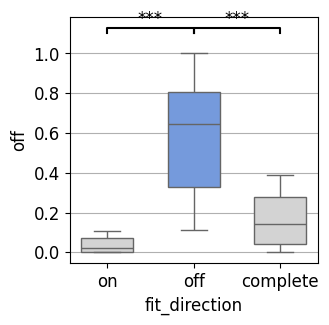

In [23]:
fig, ax = plt.subplots(figsize=(3.2, 3.2))
sns.boxplot(temp_, y='off', x='fit_direction',
             fill=True, palette=['lightgrey', 'cornflowerblue', 'lightgrey'], 
             order=['on', 'off', 'complete'], width=.6, whis=.5, showfliers=False,
)

ylim = ax.get_ylim()
yrange = ylim[1] - ylim[0]
h = 0.02*yrange
offset = 0.05 * yrange
y = ylim[1] + offset
x1, x2 = 0, 1
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black')
ax.text((x1+x2)/2, y+h*2, '***', ha='center')

x1, x2 = 1, 2
ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], color='black')
ax.text((x1+x2)/2, y+h*2, '***', ha='center')



ax.grid(axis='y')
fig.savefig('../figures/fig2D_S_mvmodel_diroff.pdf')